In [38]:
! pip install librosa
! pip install pandas
! pip install plotly

  Using cached numpy-1.21.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
astropy 6.0.0 requires numpy<2,>=1.22, but you have numpy 1.21.6 which is incompatible.
pandas 2.1.3 requires numpy<2,>=1.22.4; python_version < "3.11", but you have numpy 1.21.6 which is incompatible.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.2 which is incompatible.
sagemaker 2.199.0 requires urllib3<1.27, but you have urllib3 2.1.0 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incom

## Import Libraries and Set up Environment
import necessary libraries and adjusts the system path for modules

In [181]:
import sys
sys.path.append('../')

import boto3
import os
import pandas as pd
import io
import warnings
import yaml
from src.s3_utils import download_s3_object_to_memory, \
                         read_selection_table_fromS3

## Load AWS S3 Credentials
Load AWS S3 credentials and initializes the S3 client

In [182]:
# Load AWS S3 credentials from YAML file
with open('../config/connection_config.yaml', 'r') as f:
    credentials = yaml.safe_load(f)

# Set up AWS S3 client
s3 = boto3.client(
    's3', 
    aws_access_key_id=credentials['access_key'], 
    aws_secret_access_key=credentials['secret_access_key']
)

 ## Download and Merge Data from S3 Buckets
 iterates over a list of S3 buckets, download data, and merge it into a single DataFrame

In [188]:
# Empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Hardcoded file path and list of bucket names
file_path = "labels/labels.csv"
bucket_names = ["tangkahan", "way-kambas", "bukit-tiga-puluh", "sabah"]  # Add more as needed

# Looping through each bucket to download and merge data
for bucket_name in bucket_names:
    try:
        s3_object_bytes = download_s3_object_to_memory(bucket_name, file_path, s3)
        if s3_object_bytes is not None:
            # Read the data into a DataFrame
            new_df = pd.read_csv(s3_object_bytes)
            new_df["location"] = bucket_name

            # Merge with the existing DataFrame
            merged_df = pd.concat([merged_df, new_df], ignore_index=True)
        else:
            warnings.warn(f"Data from {bucket_name}/{file_path} could not be read.")
    except Exception as e:
        warning_message = f"Failed to merge data from {bucket_name}/{file_path}. Exception: {e}"
        warnings.warn(warning_message)

# merged_df now contains the merged data from all the buckets


## Calculate Sound Type Counts
Groups the merged data by sound category and type, counts the occurrences, and sorts the results.

In [193]:
# Group data by sound category and type, then count occurrences
sound_counts = merged_df.groupby(['sound_category', 'sound_type']).\
    size().\
    reset_index(name='count').\
    sort_values('count', ascending=False)

sound_counts

,sound_category,sound_type,count
12,elephant_vocalization,rumble,1575
15,elephant_vocalization,trumpet,764
9,elephant_vocalization,musth,708
5,elephant_vocalization,growl,436
2,elephant_sound,snort,196
10,elephant_vocalization,roar,186
1,elephant_sound,fart,149
3,elephant_sound,unidentified,111
14,elephant_vocalization,squeak,80
11,elephant_vocalization,roar_rumble,52


## Create Faceted Bar Chart

In [194]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Get unique sound categories for faceting
unique_categories = sound_counts["sound_category"].unique()

# Determine max count for uniform y-axis range
max_count = sound_counts['count'].max()

# Calculate column widths based on category counts
column_widths = [len(sound_counts[sound_counts["sound_category"] == cat]) 
                 for cat in unique_categories]
normalized_widths = [width / sum(column_widths) 
                     for width in column_widths]

# Define custom subplot titles
subplot_titles = {"elephant_vocalization": "Vocalizations", 
                  "elephant_sound": "Sounds"}
titles = [subplot_titles[cat] for cat in unique_categories]

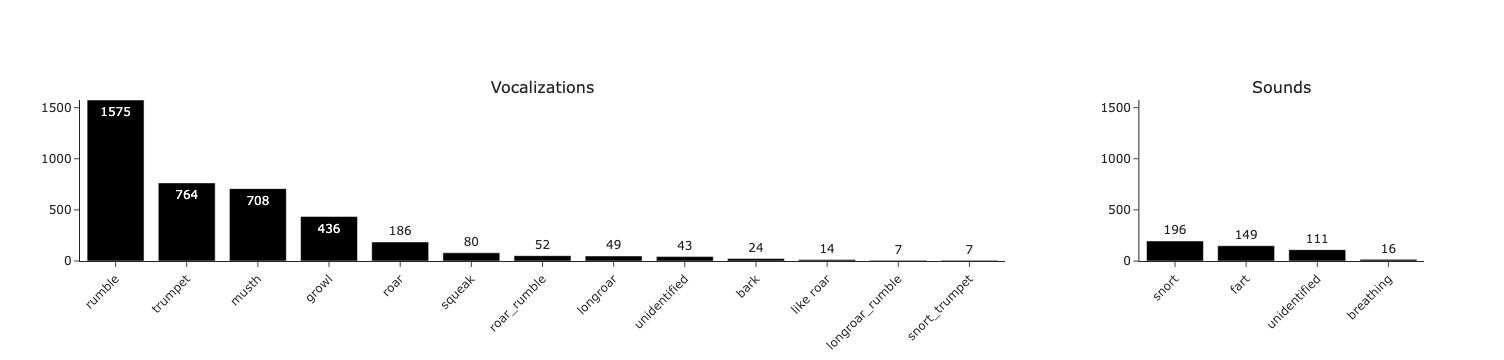

In [195]:
# Create subplots
fig = make_subplots(rows=1, cols=len(unique_categories), 
                    subplot_titles=titles, 
                    column_widths=normalized_widths)

# Populate each subplot
for i, category in enumerate(unique_categories, start=1):
    category_data = sound_counts[sound_counts["sound_category"] == category]
    fig.add_trace(go.Bar(x=category_data["sound_type"], 
                         y=category_data["count"], 
                         marker_color='black', 
                         text=category_data['count'], 
                         textposition='auto'), 
                  row=1, col=i)

# Standardize y-axis range and x-axis label angle
fig.update_yaxes(range=[0, max_count])
fig.update_xaxes(tickangle=-45)

# Finalize and display the plot
fig.update_layout(template="simple_white", showlegend=False)
fig.show()


## create a table more precises

In [197]:
# Group data by sound category, location, and type, then count
sound_counts_loc = merged_df.groupby(['sound_category', 'location', 'sound_type'])\
    .size()\
    .reset_index(name='count')\
    .sort_values(by=["sound_category", "count"], ascending=[False, False])

sound_counts_loc

,sound_category,location,sound_type,count
27,elephant_vocalization,tangkahan,rumble,1381
32,elephant_vocalization,way-kambas,musth,708
29,elephant_vocalization,tangkahan,trumpet,519
21,elephant_vocalization,tangkahan,growl,207
35,elephant_vocalization,way-kambas,rumble,172
12,elephant_vocalization,bukit-tiga-puluh,trumpet,148
31,elephant_vocalization,way-kambas,growl,112
8,elephant_vocalization,bukit-tiga-puluh,growl,110
25,elephant_vocalization,tangkahan,roar,101
36,elephant_vocalization,way-kambas,squeak,80


In [198]:
# Create pivot table with locations as columns
pivot_table_loc = sound_counts_loc.pivot_table(
    index=['sound_category', 'sound_type'], 
    columns='location', 
    values='count', 
    fill_value=None
)

pivot_table_loc


location                               bukit-tiga-puluh  sabah  tangkahan  \
sound_category        sound_type                                            
elephant_sound        breathing                     NaN    NaN       16.0   
                      fart                          8.0    NaN      141.0   
                      snort                         NaN    5.0      124.0   
                      unidentified                 15.0    NaN       96.0   
elephant_vocalization bark                          NaN    3.0       21.0   
                      growl                       110.0    7.0      207.0   
                      like roar                     NaN    NaN       14.0   
                      longroar                      NaN   16.0       33.0   
                      longroar_rumble               NaN    NaN        7.0   
                      musth                         NaN    NaN        NaN   
                      roar                         51.0   18.0      101.0   
                      roar_rumble                  20.0    4.0       15.0   
                      rumble                       14.0    8.0     1381.0   
                      snort_trumpet                 NaN    NaN        7.0   
                      squeak                        NaN    NaN        NaN   
                      trumpet                     148.0   23.0      519.0   
                      unidentified                  NaN    NaN       43.0   

location                               way-kambas  
sound_category        sound_type                   
elephant_sound        breathing               NaN  
                      fart                    NaN  
                      snort                  67.0  
                      unidentified            NaN  
elephant_vocalization bark                    NaN  
                      growl                 112.0  
                      like roar               NaN  
                      longroar                NaN  
                      longroar_rumble         NaN  
                      musth                 708.0  
                      roar                   16.0  
                      roar_rumble            13.0  
                      rumble                172.0  
                      snort_trumpet           NaN  
                      squeak                 80.0  
                      trumpet                74.0  
                      unidentified            NaN